In [5]:
import pandas as pd
import numpy as np
import nltk
import json
import re
from tqdm import tqdm
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from string import punctuation
from autocorrect import spell

In [12]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# pip install autocorrect

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
df=pd.read_json('/content/drive/MyDrive/Bigdata/amazon.json', lines = True)

In [ ]:
df.shape

(100000, 12)

In [ ]:
df.isna().sum()

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName          5
reviewText           57
summary              66
unixReviewTime        0
vote              75331
image             99340
style             62166
dtype: int64

In [7]:
snowball_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

In [8]:
def clean(df):
  df.drop(columns=['reviewerName', 'image','style'], inplace=True)
  df[['reviewText', 'summary']]=df[['reviewText', 'summary']].fillna( value='')
  df['reviewText'] = df['reviewText'].astype(str) +" "+ df['summary']
  df.drop(columns=['summary'], inplace=True)
  df["feedback"] = df["overall"].apply(lambda x:'good' if x >= 3 else 'bad')
  df.drop_duplicates(subset=['asin','reviewerID','unixReviewTime'], inplace=True)
  df.reset_index(drop=True, inplace=True)
  df['vote']=pd.to_numeric(df['vote'], errors='coerce', downcast='integer')
  df['vote']=df.groupby('asin')['vote'].transform(lambda x: x.fillna(x.mean()))
  df['vote']=df['vote'].bfill(axis='rows')
  df['vote']=df['vote'].astype(int)
  return df

In [9]:
def autospell(text):
  #correct the spelling of the word.

  spells = [spell(w) for w in (nltk.word_tokenize(text))]
  return " ".join(spells)

def to_lower(text):
  #Returns converted text to lower case as in, converting "Hello" to "hello" or "HELLO" to "hello".
  return text.lower()

def remove_numbers(text):
  #take string input and return a clean text without numbers.
  #Use regex to discard the numbers.

  output = ''.join(c for c in text if not c.isdigit())
  return output

def remove_punct(text):
  #take string input and clean string without punctuations.
  #use regex to remove the punctuations.
 
  return ''.join(c for c in text if c not in punctuation)

def remove_Tags(text):
  #take string input and clean string without tags.
  #use regex to remove the html tags.
  
  cleaned_text = re.sub('<[^<]+?>', '', text)
  return cleaned_text

def sentence_tokenize(text):
  #take string input and return list of sentences.
  #use nltk.sent_tokenize() to split the sentences.

  sent_list = []
  for w in nltk.sent_tokenize(text):
      sent_list.append(w)
  return sent_list

def word_tokenize(text):
  #returns list of words

  return len([w for sent in nltk.sent_tokenize(text) for w in nltk.word_tokenize(sent)])

def remove_stopwords(sentence):
  #removes all the stop words like "is,the,a, etc."
  
  stop_words = stopwords.words('english')
  return ' '.join([w for w in nltk.word_tokenize(sentence) if not w in stop_words])

def stem(text):
  # take word tokens and returns list of stemmed words

  stemmed_word = [snowball_stemmer.stem(word) for sent in nltk.sent_tokenize(text)for word in nltk.word_tokenize(sent)]
  return " ".join(stemmed_word)

def lemmatize(text):
  lemmatized_word = [wordnet_lemmatizer.lemmatize(word)for sent in nltk.sent_tokenize(text)for word in nltk.word_tokenize(sent)]
  return " ".join(lemmatized_word)

In [10]:
def preprocess(text):
  lower_text = to_lower(text)
  sentence_tokens = sentence_tokenize(lower_text)
  word_list = []
  for each_sent in sentence_tokens:
    lemmatizzed_sent = lemmatize(each_sent)
    clean_text = remove_numbers(lemmatizzed_sent)
    clean_text = remove_punct(clean_text)
    clean_text = remove_Tags(clean_text)
    word_list = remove_stopwords(clean_text)
  return word_list

In [15]:
df=clean(df)
for i in tqdm(range(len(df))):
   df['reviewText'][i]=preprocess(str(df['reviewText'][i]))

  0%|          | 0/99234 [00:00<?, ?it/s]<ipython-input-15-f712032e5c2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviewText'][i]=preprocess(str(df['reviewText'][i]))
100%|██████████| 99234/99234 [05:04<00:00, 325.41it/s]


In [ ]:
#total reviews on each product
g1=df.groupby('asin')['reviewerID'].count()
print(g1,'\n\n')

#number of unique reviwers
print('Unique reviewers: ', df['reviewerID'].nunique(),'\n\n')

#number of unique products
print('Unique products: ', df['asin'].nunique(),'\n\n')

#number of good reviwes
print('Good reviews: ', (df['feedback'][df['feedback']=='good']).count(),'\n\n')

#number of bad reviwes
print('Bad reviews: ', (df['feedback'][df['feedback']=='bad']).count(),'\n\n')

#number of reviews coresponding each overall rating for each product
g2=df.groupby(['asin', 'overall'])['reviewerID'].count()
print(g2,'\n\n')


asin
0143026860       7
014789302X      10
0992916305       6
1620213982    4782
162209798X       4
              ... 
B01HIUSO7U       2
B01HIYSW0U       1
B01HJ0BX2C       1
B01HJ5EDTC       3
B01HJCS4HC       1
Name: reviewerID, Length: 3269, dtype: int64 


Unique reviewers:  92174 


Unique products:  3269 


Good reviews:  79623 


Bad reviews:  19611 


asin        overall
0143026860  1          1
            4          3
            5          3
014789302X  1          2
            2          1
                      ..
B01HIYSW0U  4          1
B01HJ0BX2C  5          1
B01HJ5EDTC  3          1
            5          2
B01HJCS4HC  5          1
Name: reviewerID, Length: 8167, dtype: int64 




In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

<ipython-input-70-45d7bdcfca59>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


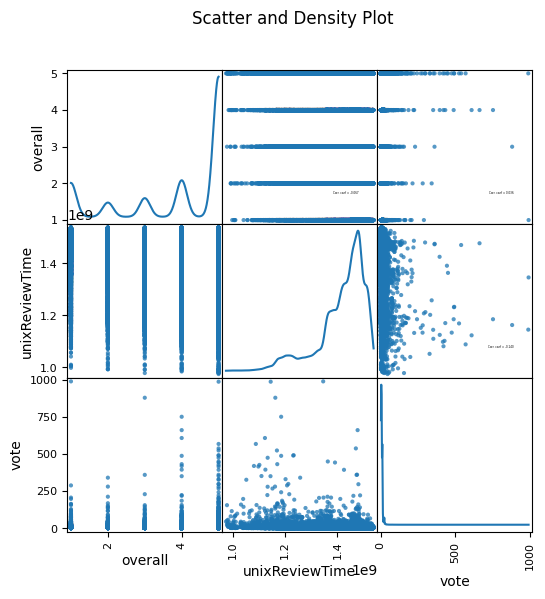

In [ ]:
plotScatterMatrix(df, 6, 2)